## Imports and preparations

In [18]:
import pandas as pd
import numpy as np
import csv
import math
from matplotlib import pyplot as plt
from calendar import month_abbr
from preprocessing_utils import transform_categorical_column, parse_browser_col
from time import strptime
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, impute
from model_estimation import estimate_model_performance
from preprocessing_utils import EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder, MONTH_COL, standardize_data
from sklearn.model_selection import train_test_split
import seaborn as sns
from data_completeness import fill_special_cols, fill_duration_zeros, impute_knn_missing_data, fill_total_duration
from remove_outliers import impute_zscore_test
from dimension_reduction import compare_pca_and_forward_selection
import warnings 

warnings.filterwarnings('ignore')

In [69]:
train_data = pd.read_csv("train.csv")

In [79]:
test_data = pd.read_csv("test.csv")

## Data Exploration

### We will start with a glimpse of data and its features:

In [21]:
pd.set_option('display.max_columns', None)

In [22]:
print(f"Data description:")
train_data.describe()

Data description:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
count,10479.00000,9874.000000,10066.000000,9792.000000,10076.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10156.000000,10460.000000,10456.000000,105.000000,10479.000000
mean,5239.00000,2.321957,80.462468,0.502655,31.870187,1302.457216,0.021854,0.042859,5.900387,0.061985,2.122981,3.155641,99.769628,4.060440,0.154690
std,3025.17107,3.335331,179.217548,1.265812,44.816259,2039.312905,0.048100,0.048297,18.727496,0.199429,0.906859,2.404672,10.050268,2.189818,0.361626
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,60.733919,-1.235571,0.000000
25%,2619.50000,0.000000,0.000000,0.000000,7.000000,221.000000,0.000000,0.014283,0.000000,0.000000,2.000000,1.000000,93.030568,3.141657,0.000000
50%,5239.00000,1.000000,8.000000,0.000000,18.000000,677.851191,0.002968,0.025161,0.000000,0.000000,2.000000,3.000000,99.787249,4.432221,0.000000
75%,7858.50000,4.000000,93.000000,0.000000,38.000000,1605.733333,0.016667,0.050000,0.000000,0.000000,3.000000,4.000000,106.506626,5.531061,0.000000
max,10478.00000,27.000000,3398.750000,24.000000,705.000000,47850.920680,0.200000,0.200000,361.763742,1.000000,8.000000,9.000000,141.735142,7.618254,1.000000


In [23]:
print(f"Data glimpse:")
train_data.head()

Data glimpse:


,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
0,0,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.0,0.0,Feb,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,1,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,0.000000,0.200000,0.200000,0.0,0.0,Feb,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,2,0.0,0.0,0.0,NaN,NaN,627.5 minutes,627.500000,0.020000,0.050000,0.0,0.0,Feb,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,3,0.0,0.0,0.0,0.0 minutes,19.0,154.2166667 minutes,154.216667,0.015789,0.024561,0.0,0.0,Feb,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,4,0.0,0.0,0.0,0.0 minutes,1.0,0.0 minutes,NaN,0.200000,0.200000,0.0,0.4,Feb,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0


In [24]:
print(f"Number of rows: {train_data.shape[0]}")
print(f"Number of features: {train_data.shape[1]-1}")

Number of rows: 10479
Number of features: 22


In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10479 entries, 0 to 10478
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10479 non-null  int64  
 1   num_of_admin_pages     9874 non-null   float64
 2   admin_page_duration    10066 non-null  float64
 3   num_of_info_pages      9792 non-null   float64
 4   info_page_duration     10162 non-null  object 
 5   num_of_product_pages   10076 non-null  float64
 6   product_page_duration  9858 non-null   object 
 7   total_duration         5726 non-null   float64
 8   BounceRates            10457 non-null  float64
 9   ExitRates              10453 non-null  float64
 10  PageValues             10452 non-null  float64
 11  closeness_to_holiday   9983 non-null   float64
 12  Month                  10454 non-null  object 
 13  device                 10156 non-null  float64
 14  internet_browser       9916 non-null   object 
 15  Re

At first, we tried to look at the data and get familiar with it how it looks, and which data types are used for each column.
We used df.describe, df. head and df.info to just have a glimpse at the data and "feel" how it behaves.
It will later help us to understand how we would like to manipulate it in our favor.

### Let's try to see how that data distributes:

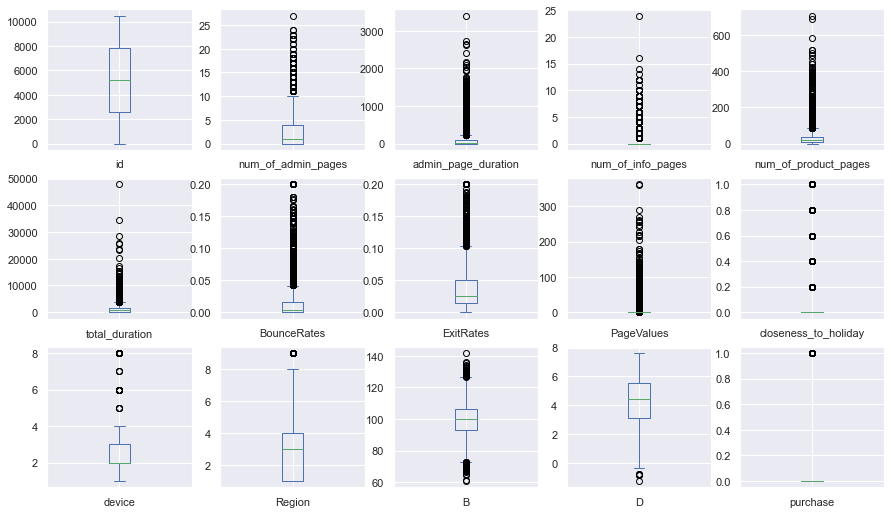

In [26]:
train_data.plot(kind="box", subplots=True,layout = (5,5), figsize=(15,15));

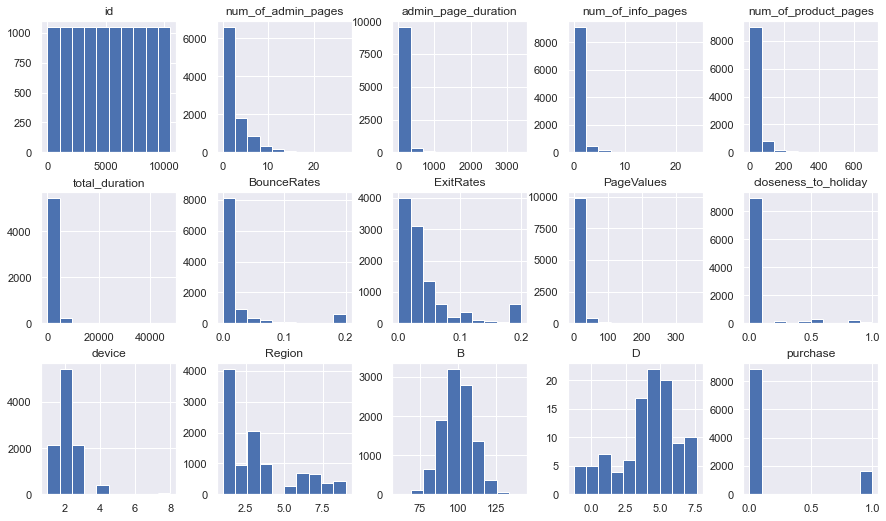

In [27]:
train_data.hist(layout = (5,5), figsize=(15,15));

These two plots help us understand a few things:
1. Not all of the columns are relevant for plotting as they are - like ID and purchase. These are fixed values and it's irrelevant to see their distributions.
2. Some of the coulums are normally distributed, or close to it - like column "B", "D" and "Device".
3. We can easily identify some of the otliers. For example - the values "6" and "8" in "Device" column, some of the durations etc. We will deal with it in a later stage.

### Feature correlation:

<AxesSubplot:>

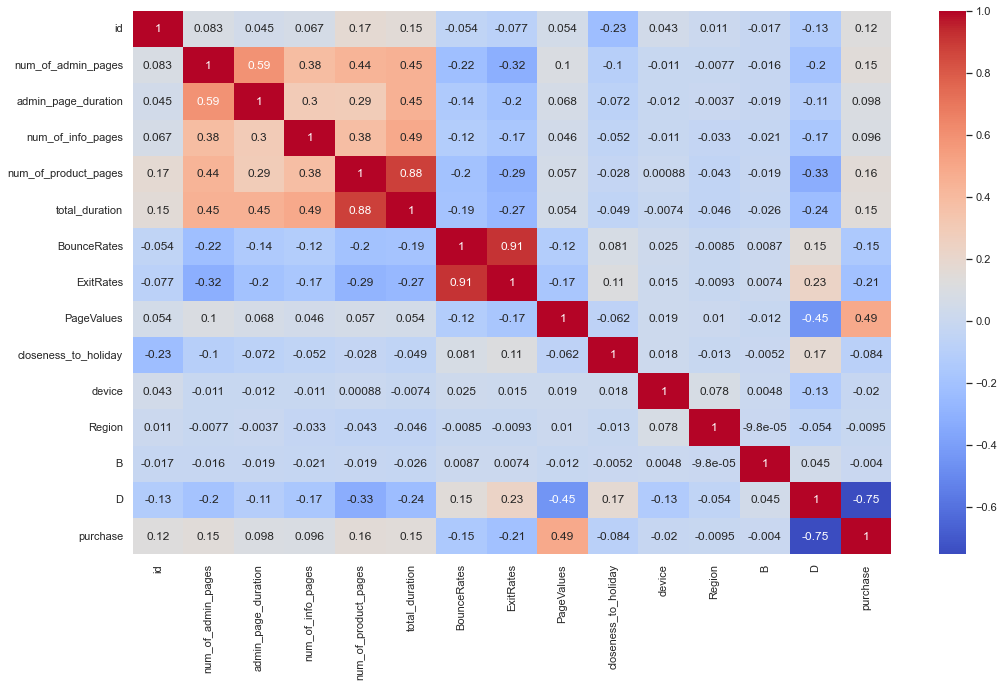

In [28]:
sns.set(rc={'figure.figsize':(17, 10)})
sns.heatmap(train_data.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

Notes from correlation matrix:
&nbsp;
1. **BounceRates and ExitRates have very high correlation** - 0.91 . Looking at the features explenations their meaning sounds very much alike, this can explain the similarity. We can use only one of them,  let's start with using ExitRates as a slightly better correlation with purchase, but we can validate it more thoroughly with methods such as forward selection.
&nbsp;
2. **Pages number and duration** - Total_duration and num_of_product_pages are also highly correlated - 0.98. After learning the relation of the different duration columns before, we can  explain it if most of the session time is dedicated to reviewing products. In general, all those column are relatively correlated and it seems like some of them are redundant. We can choose a strict reduction and take total duraion + only number of pages without duration, or a more "loose" reduction of removing only "total duration" as you can imply it from the other columns.
&nbsp;
3. **D is strongly negatively correlated (-0.75) to purchase,** which is the label we'll be trying to predict. It is interesting as earlier we have noticed most of its values are Nan. Below we've tried to look deeper on the connection between the two by grouping them together and counting how many sessions fit to each combination, and it looks like the ratio of purchase vs not is pretty much the same whether there is D or not.
&nbsp;
4. Other than this, the column most correlated with purchase is **PageValues** (0.49). It also makes sense as usually if the user exists without making a purchase, it hints a 0 value. If a purchase was made, it is very likely the value will be highter than 0. Below a mode detail validation on this theory. We expect to also see this with feature selection.
&nbsp;
&nbsp;
<br>
<br>
__Conclusions:__
- We'll try using only total duration and the number of pages and drop the other durations.
- We'll drop BoundRates and use only ExitRates
Those conclusions should be varified but we'll get to it later when we measure model performance for evaluation.

In [29]:
"""
Check connection between pages to the existence of page value (higher than 0).
It is noticeable that it's much more likely that if value == 0, a purchase was made and vice versa.
"""
pg_value_to_purchase = pd.DataFrame()
pg_value_to_purchase['purchase'] = train_data['purchase']
pg_value_to_purchase['is_page_value'] = train_data['PageValues'].apply(lambda x: x != 0)
pg_value_to_purchase.groupby(['purchase', 'is_page_value']).size()

purchase  is_page_value
0         False            7829
          True             1029
1         False             309
          True             1312
dtype: int64

In [64]:
# Check the connection between D and purchase, is it an interesting column to indicate purchase (doesn't seem so)
train_data_d = train_data.copy()
train_data_d['no_D'] = train_data_d.D == -999
train_data_d[['no_D', 'purchase','id']].groupby(['no_D', 'purchase']).count()

id
no_D  purchase      
False 0         8858
      1         1621

## Data cleaning

Our end goal is to have all our columns in a numeric form, without missing data.
We can see from the returned values above that there are some columns that should be interpreted as integers, and not as floats (num_of_X_pages, region, device...).
In addition, it wouldn't be smart to assume column "A"'s and "C"'s empty values using KNN, since a value is fixed. We will use a different approach for it.
Moreover, we will fill NaN values for user_type as Others, since we can't assume the real type.

In [66]:
column_list = train_data.columns.values.tolist()
column_list.sort()
for column_name in column_list:
    if column_name not in ['id', 'purchase']:
        print(f"""Column: "{column_name}" ; Unique values: {list(train_data[column_name].unique())[:15]}""")

Column: "A" ; Unique values: ['c_1', 'c_3', 'c_4', 'c_2', nan, 'c_5', 'c_6', 'c_8', 'c_10', 'c_11', 'c_9', 'c_7', 'c_13', 'c_14', 'c_15']
Column: "B" ; Unique values: [118.8800944, 113.3584226, 121.5076952, 93.74717575, 99.54582421, 104.7124049, 89.78656794, 101.1845339, 83.93173925, 97.89963262, 101.2214824, 95.51998611, 109.3586319, 111.5479879, 113.2126221]
Column: "BounceRates" ; Unique values: [0.2, 0.02, 0.015789474, 0.0, 0.01875, 0.008333333, 0.002857143, 0.05, 0.043478261, 0.04, 0.014285714, 0.015384615, 0.025, 0.028571429, 0.003030303]
Column: "C" ; Unique values: ['log202', 'log404', 'log_100', 'log200', 'log400', 'log8080', nan]
Column: "D" ; Unique values: [nan, 7.257360853, 5.521225205, 4.34878126, 5.011107258, 5.531061246, 3.274955241, 0.796733734, 3.816877219, 0.058866821, 7.618253527, 4.826132322, 3.305456104, 5.386814934, 4.319823481]
Column: "ExitRates" ; Unique values: [0.2, 0.05, 0.024561404, 0.1, 0.022222222, 0.066666667, 0.025833333, 0.028571429, 0.016312636, 0.00

Now that we know which unique values we have in our set, we can transform it in a way that would fit the ML models.

In [70]:
clean_train_data = standardize_data(train_data, EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder.ORDINAL, MONTH_COL)

The next thing we want to check out is whether we have missing data. We did see in the data glimpse that some of the values are filled with NaNs, so we we'd like to see what's the best way to deal with it.

In [71]:
data_summary = pd.DataFrame()
data_summary['missing'] = clean_train_data.isna().sum()
data_summary['percentile'] = (data_summary.missing / clean_train_data.shape[0]) * 100
data_summary.sort_values(by='missing', ascending=False)

,missing,percentile
D,10374,98.997996
total_duration,4753,45.357381
A,706,6.737284
num_of_info_pages,687,6.555969
product_page_duration,621,5.926138
num_of_admin_pages,605,5.773452
closeness_to_holiday,496,4.733276
admin_page_duration,413,3.941216
num_of_product_pages,403,3.845787
device,323,3.082355


As we can see, column "D" and "total_duration" have the most NaN values. Let's try to see what's special about them:

In [72]:
clean_train_data[clean_train_data["D"].notna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,Region,user_type,Weekend,A,B,C,D,purchase,browser_name,browser_version
34,34,0.0,0.000000,0.0,0.0,9.0,482.0,NaN,0.000000,0.022222,0.000000,0.0,2.0,2.0,1.0,2.0,0,c_6,97.305385,log8080,7.257361,0,0.0,5.0
179,179,2.0,40.000000,0.0,0.0,5.0,558.5,598.500000,0.000000,0.028571,0.000000,0.0,3.0,2.0,7.0,0.0,1,c_2,100.425325,log_100,5.521225,0,1.0,90.0
222,222,1.0,13.000000,0.0,0.0,2.0,20.0,NaN,0.000000,0.050000,0.000000,0.0,3.0,3.0,3.0,2.0,0,c_2,104.686348,log200,4.348781,0,1.0,98.0
328,328,4.0,61.000000,0.0,0.0,14.0,175.666667,NaN,0.000000,0.010588,0.000000,0.0,3.0,2.0,5.0,2.0,0,c_2,93.755824,log202,5.011107,0,1.0,80.0
346,346,7.0,151.000000,0.0,0.0,44.0,1406.1,NaN,0.004082,0.006501,0.000000,0.0,3.0,1.0,4.0,2.0,0,c_2,83.061903,log200,5.531061,0,3.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9779,9779,0.0,0.000000,0.0,0.0,12.0,1952.75,NaN,0.033333,0.068333,0.000000,NaN,11.0,2.0,8.0,2.0,0,c_1,115.233372,log404,1.632070,0,2.0,99.0
9924,9924,0.0,0.000000,0.0,0.0,57.0,1234.5,NaN,0.001724,0.020690,0.000000,0.0,11.0,2.0,2.0,2.0,1,c_2,90.084329,log400,2.905838,0,0.0,7.0
10282,10282,10.0,260.250000,0.0,0.0,31.0,1694.333333,1954.583333,0.017143,0.039048,15.108543,0.0,11.0,2.0,4.0,2.0,0,c_3,91.706110,log400,3.932566,0,1.0,99.0
10388,10388,0.0,0.000000,6.0,97.166667,81.0,3466.794048,NaN,0.018431,0.022050,0.000000,0.0,11.0,3.0,1.0,2.0,1,c_13,80.989223,log_100,4.842721,0,4.0,0.0


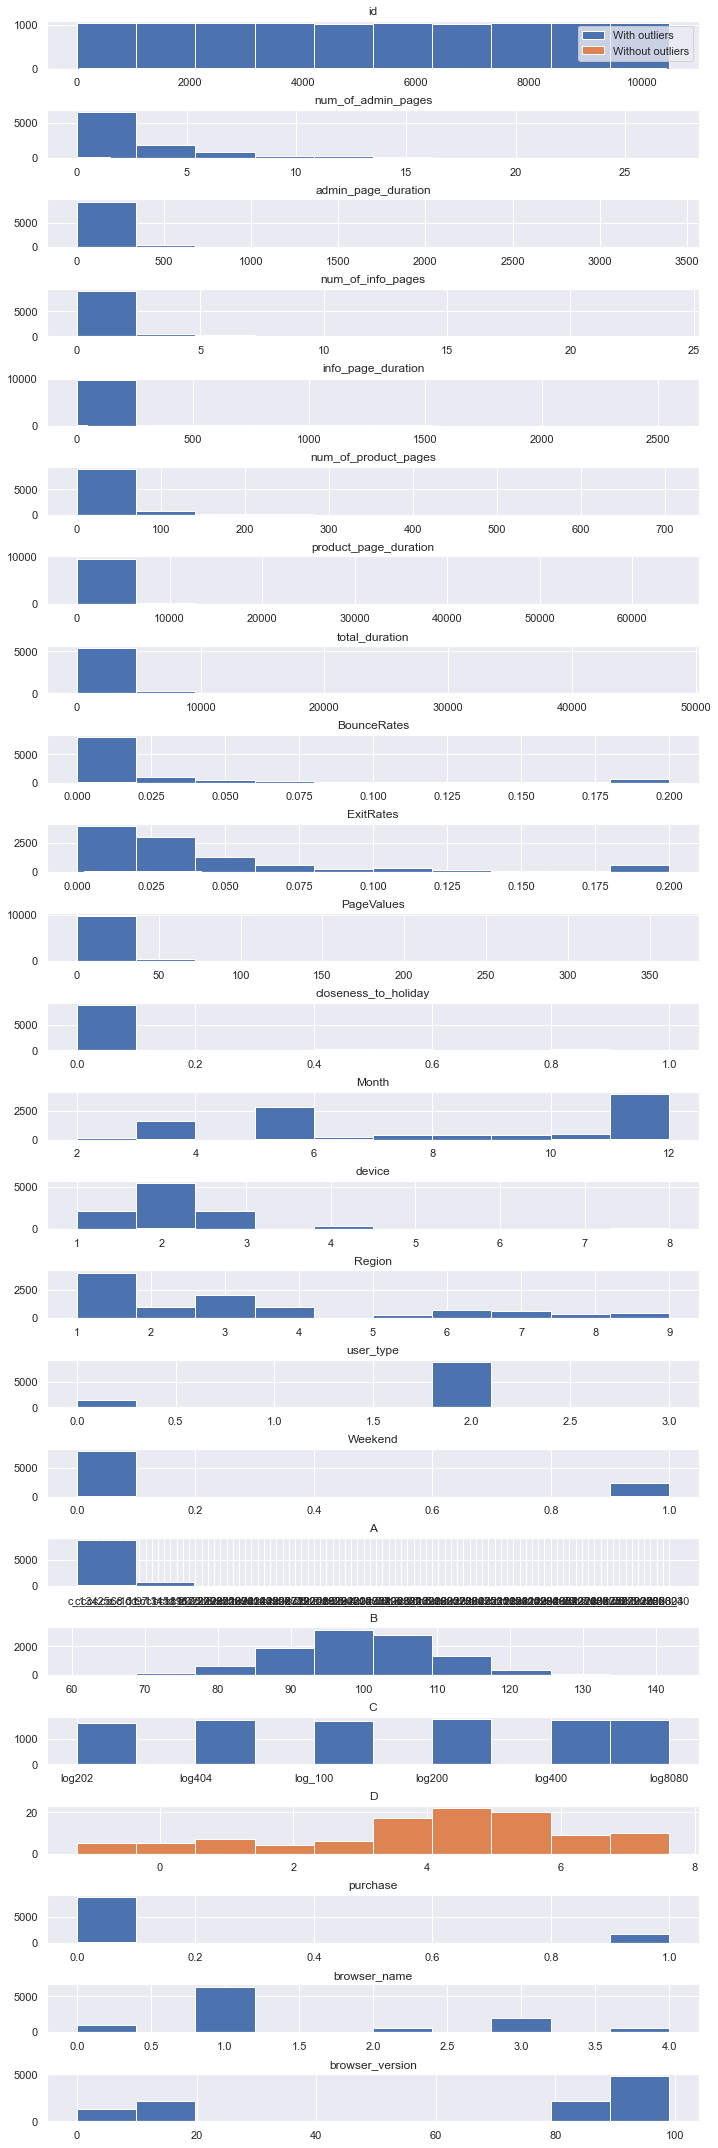

In [73]:
fig, axes = plt.subplots(len(clean_train_data[clean_train_data["D"].notna()].columns), 1, figsize=(10, 30))
fig.tight_layout(pad=1.5)

i=0
for col in clean_train_data[clean_train_data["D"].notna()].columns:
    clean_train_data[clean_train_data["D"].isna()][col].hist(ax=axes[i])
    clean_train_data[clean_train_data["D"].notna()][col].hist(ax=axes[i])
    axes[i].title.set_text(col)
    i+=1
axes[0].legend(["With outliers", "Without outliers"])


As there not seems to be much change in the data between empty and non empty "D" values, and we saw that the range for the "D" values are -1.23 to 7.61, we will fill it for now with -999.
Because we don't know what column D really stands for, and almost all of the values are empty, we prefer not to try to predict their values.

In [74]:
#TODO: figure out what to do with D

Let's move to total_duration:

In [75]:
clean_train_data[clean_train_data["total_duration"].notna()]

,id,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,Month,device,Region,user_type,Weekend,A,B,C,D,purchase,browser_name,browser_version
1,1,0.0,0.00,0.0,0.0,1.0,0.0,0.000000,0.200000,0.200000,0.000000,0.0,2.0,4.0,9.0,2.0,0,c_3,113.358423,log404,NaN,0,3.0,14.0
2,2,0.0,0.00,0.0,NaN,NaN,627.5,627.500000,0.020000,0.050000,0.000000,0.0,2.0,3.0,1.0,2.0,1,c_4,121.507695,log202,NaN,0,0.0,3.0
3,3,0.0,0.00,0.0,0.0,19.0,154.216667,154.216667,0.015789,0.024561,0.000000,0.0,2.0,2.0,1.0,2.0,0,c_3,93.747176,log_100,NaN,0,1.0,99.0
7,7,0.0,0.00,0.0,0.0,3.0,395.0,395.000000,0.000000,0.066667,0.000000,0.0,2.0,1.0,3.0,2.0,0,c_3,101.184534,log_100,NaN,0,3.0,15.0
9,9,0.0,0.00,0.0,0.0,7.0,280.5,280.500000,0.000000,0.028571,0.000000,0.0,2.0,1.0,1.0,2.0,0,c_3,97.899633,log200,NaN,0,3.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10471,10471,0.0,0.00,0.0,0.0,6.0,0.0,0.000000,0.200000,0.200000,0.000000,0.0,11.0,1.0,4.0,2.0,0,c_1,100.346528,log400,NaN,0,0.0,8.0
10472,10472,6.0,76.25,0.0,0.0,22.0,1075.25,1151.500000,0.000000,0.004167,0.000000,0.0,12.0,2.0,4.0,2.0,0,c_2,83.053502,log8080,NaN,0,1.0,99.0
10473,10473,0.0,0.00,1.0,0.0,16.0,503.0,503.000000,0.000000,0.037647,0.000000,0.0,11.0,2.0,1.0,2.0,0,c_1,95.296930,log400,NaN,0,1.0,90.0
10474,10474,3.0,145.00,0.0,0.0,53.0,1783.791667,1928.791667,0.007143,0.029031,12.241717,0.0,12.0,4.0,1.0,2.0,1,c_1,79.548460,log400,NaN,0,0.0,6.0


It is interesting to notice when all durations columns are filled, that they all sum up to form total duration.
Sometimes we can see that the total_duration column is empty even though other durations are filled with actual values. We will fill the empty values with the sum of the other values and vice versa using this formula: admin_page_duration + info_page_duration + product_page_duration = total_duration

To do this better, we need to try and fill the other duration values.
For other fields, we will use KNN to try and fill-in the missing data. We'll start with cleaning it a little bit.

First, we'd like to see the unique values of the columns, to see if we need to pay special attention for some of the column's predictions.

In [76]:
orig = clean_train_data.copy()
filled_train_data = fill_duration_zeros(clean_train_data)
filled_train_data = fill_special_cols(filled_train_data)
filled_train_data = impute_knn_missing_data(filled_train_data)
filled_train_data = fill_total_duration(filled_train_data)
filled_train_data.shape

(10479, 24)

Finally, let's see that filled in all the NaN values:

In [77]:
data_summary = pd.DataFrame()
data_summary['missing'] = filled_train_data.isna().sum()
data_summary['percentile'] = (data_summary.missing / filled_train_data.shape[0]) * 100
data_summary.sort_values(by='missing', ascending=False)

,missing,percentile
id,0,0.0
num_of_admin_pages,0,0.0
browser_name,0,0.0
purchase,0,0.0
D,0,0.0
C,0,0.0
B,0,0.0
A,0,0.0
Weekend,0,0.0
user_type,0,0.0


### Now we will implement it on the test set as well.

In [80]:
clean_test_data = standardize_data(test_data, EXTRACT_FLOAT_COLS, BOOL_COLS, CATEGORICAL_COLS, BROWSER_COL, CategoricalEncoder.ORDINAL, MONTH_COL)

filled_test_data = fill_duration_zeros(clean_test_data)
filled_test_data = fill_special_cols(filled_test_data)
filled_test_data = impute_knn_missing_data(filled_test_data)
filled_test_data = fill_total_duration(filled_test_data)

In [81]:
data_summary_test = pd.DataFrame()
data_summary_test['missing'] = filled_test_data.isna().sum()
data_summary_test['percentile'] = (data_summary_test.missing / filled_test_data.shape[0]) * 100
data_summary_test.sort_values(by='missing', ascending=False)

,missing,percentile
id,0,0.0
Month,0,0.0
browser_name,0,0.0
D,0,0.0
C,0,0.0
B,0,0.0
A,0,0.0
Weekend,0,0.0
user_type,0,0.0
Region,0,0.0


## Removing outliers

During the data exploration we already notice that our data containes possible outliers.
Outliers could cause our predictions to be inaccurate, so we would like to remove potential outliers before moving forward.
To make sure we remove only absolute outliers, we will use a zscore test.

Zscore test usually applied on normally distributed data. As we previously seen, not all of our colums are normally distributed, but we believe that this will be covered due to the large amount of train data that we have. In addition, we will take a look at the "before and after" charts, and make sure that only obvious outleirs are filtered out for each column.

We will also exclude some columns from the test, like ID, purchase and column "D" that has very little actual data.

Original amount of rows: 10479
New amount of rows: 8365


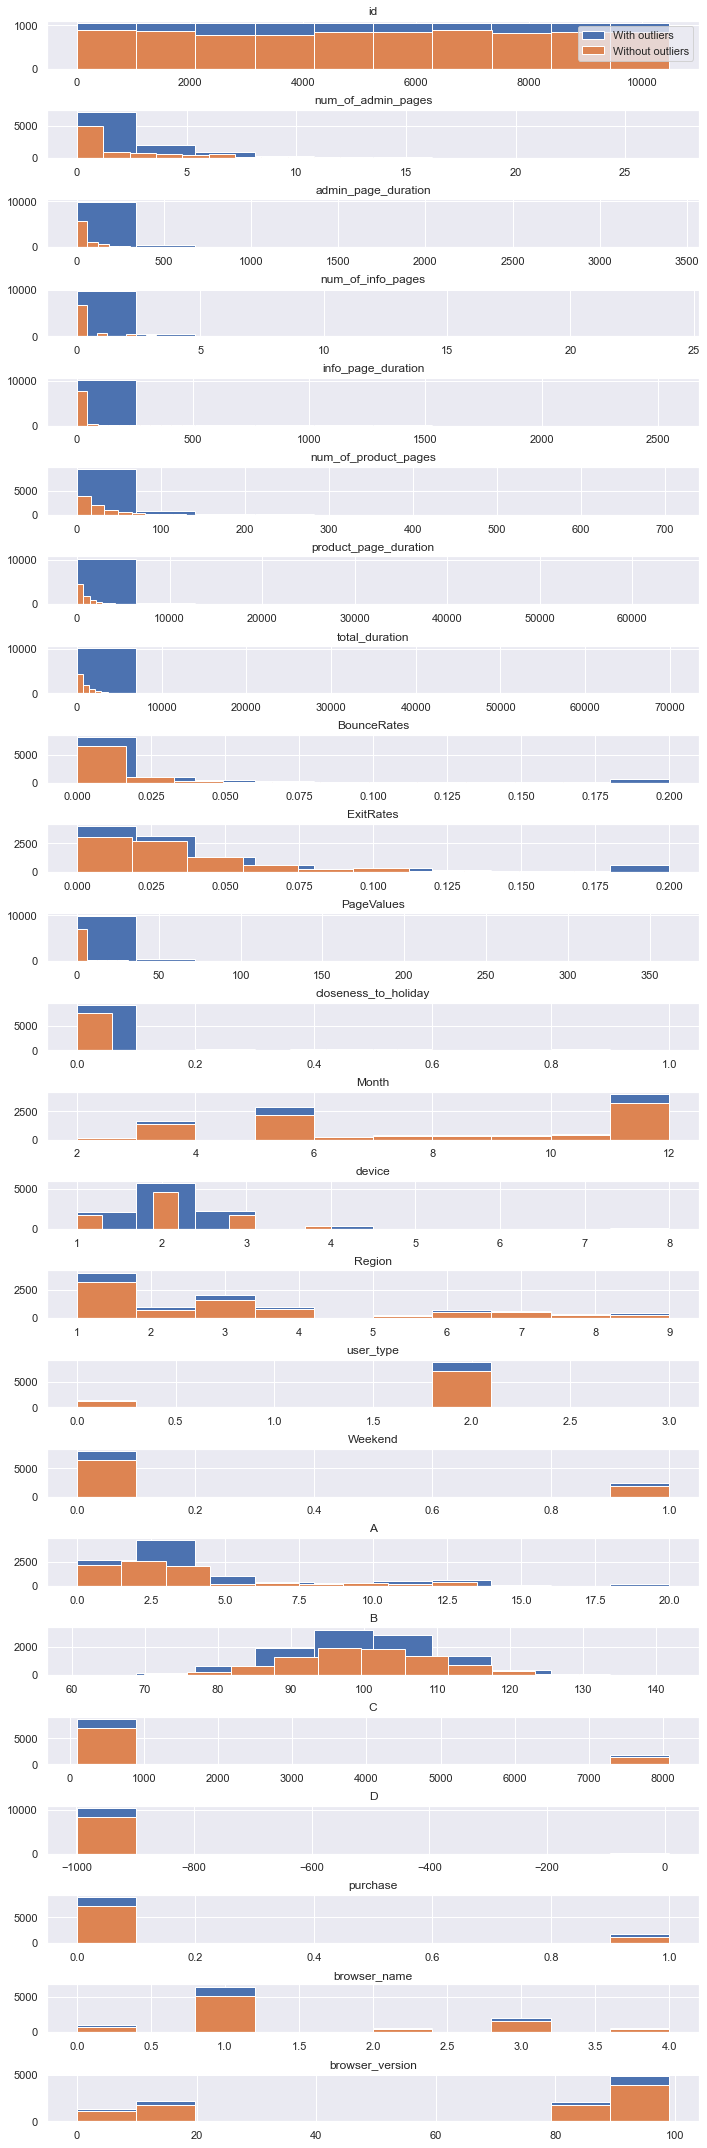

In [82]:
train_data_wo_outliers = impute_zscore_test(filled_train_data)

As it appears, the data distribution pretty much remained the same, so we are good to go.

## Now we can run our first model!

Model predictions runtime: 0.0043487548828125s
Accuracy score: 0.8882247459653317
MSE: 0.11177525403466826


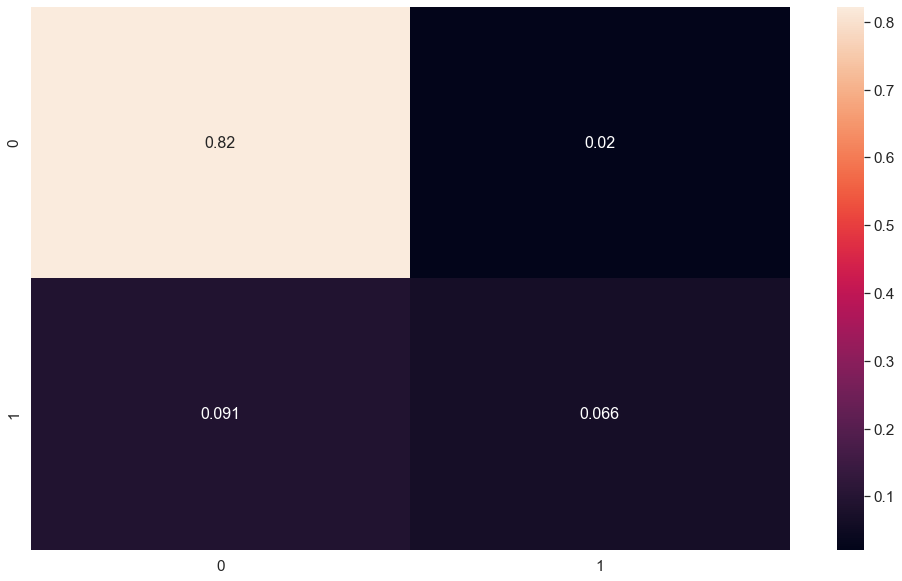

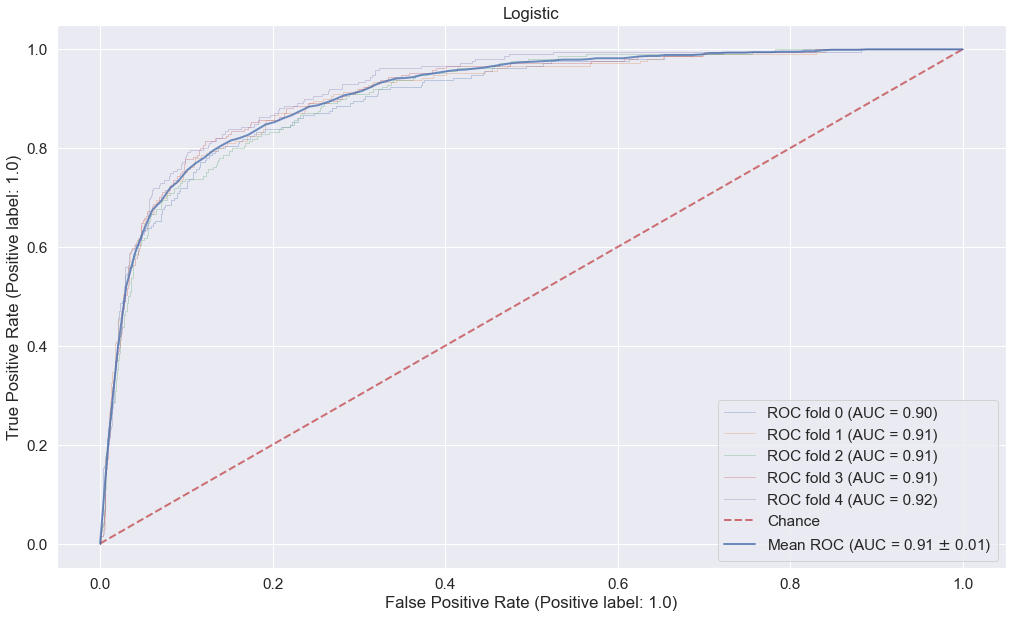

<Figure size 720x720 with 0 Axes>

In [83]:
X_train, X_test, y_train, y_test = train_test_split(train_data_wo_outliers.loc[:, train_data_wo_outliers.columns != 'purchase'], train_data_wo_outliers['purchase'], test_size=0.2)
lr = LogisticRegression(max_iter=1000000,solver='liblinear').fit(X_train, y_train)
estimate_model_performance(lr, "Logistic", X_test, y_test, 5);


As it seems, we got pretty good results on this validation set, with AUC score of 0.91. <br>
These results raise a concern of overfitting. One of our strategies to reduce overfitting is dimensional reduction, which will take place in the next chapter.

## Dimensional Reduction

We will test 2 methods - forward selection and PCA with 0.95 variance - and see which yields best performance.
We will be making some assumptions:
1. The performance evaluation will be measured using Linear Regression model, as a simple model that will be easy to predict with and measure the errors. We weren't sure what should be done first - model selection or dimension reduction - so we followed the order of the exercise, assuming linear regression will reflect impact on performance of other models as well.
2. The metric for evaluation was chosen to be RMSE after researching what metric is more often used for this use case. There is no consensus and different metrics will yield different results.
&nbsp;

To make the assment easy and comfortable, we've build a function running:
1. Forward selection - compare each number of features to the one before it and pick the best number of features subset.
2. PCA - variance of 0.95 was chosen as a const for not loosing too much of the data. Different consts would yield different results and it is configurable in change this assumption changes.

We will run all this after removing the columns suggested above ('BoundRates', 'admin_page_duration', 'product_page_duration', 'info_page_duration')

PCA RMSE: 0.28549837518183885
New best score! n=1 Best features set: ['PageValues'], RMSE: 0.28864061686020404
New best score! n=2 Best features set: ['total_duration' 'PageValues'], RMSE: 0.2870746635278705
New best score! n=3 Best features set: ['total_duration' 'PageValues' 'Month'], RMSE: 0.28525708033398534
New best score! n=5 Best features set: ['total_duration' 'ExitRates' 'PageValues' 'Month' 'user_type'], RMSE: 0.28499680507471337
New best score! n=6 Best features set: ['total_duration' 'ExitRates' 'PageValues' 'Month' 'user_type' 'Weekend'], RMSE: 0.2849788521781282
New best score! n=8 Best features set: ['num_of_product_pages' 'total_duration' 'ExitRates' 'PageValues' 'Month'
 'user_type' 'Weekend' 'C'], RMSE: 0.2849780847730767


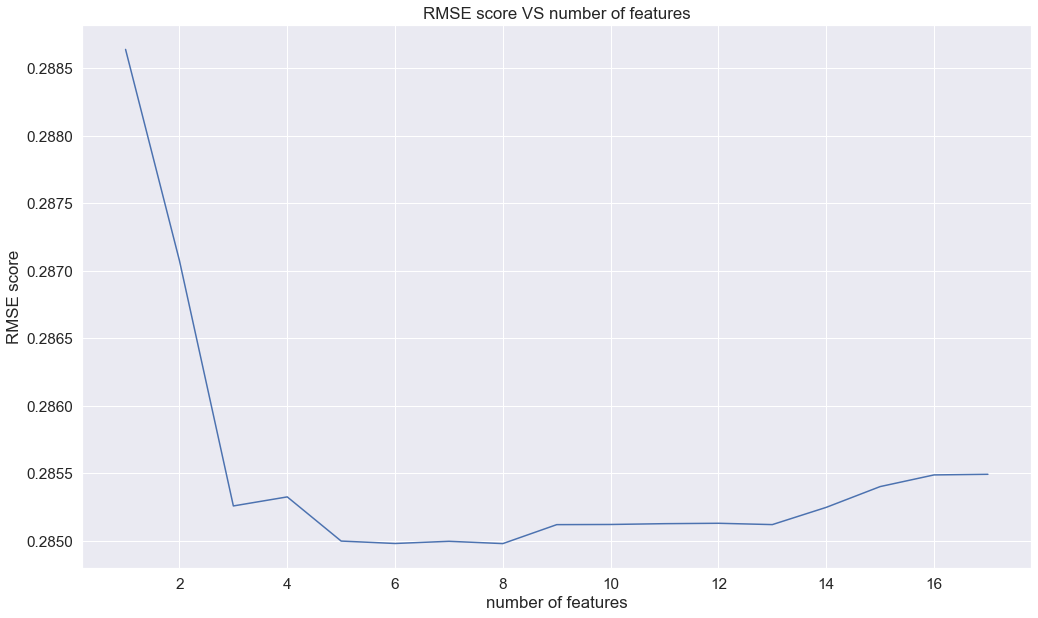

Best forward selection RMSE: 0.2849780847730767
Forward Selection scored best. Features to use: ['num_of_product_pages' 'total_duration' 'ExitRates' 'PageValues' 'Month'
 'user_type' 'Weekend' 'C']


In [88]:
# We will add id to ignored cols as it is just the row id and should not indicate anything more.
cols_not_in_x_data = ['id', 'purchase', 'BounceRates', 'admin_page_duration', 'product_page_duration', 'info_page_duration']
y = train_data_wo_outliers['purchase']
X = train_data_wo_outliers[[col for col in train_data_wo_outliers.columns if col not in cols_not_in_x_data]]
x_train, x_validation, y_train, y_validation = train_test_split(
       X, y, test_size=0.2, random_state=42, shuffle=True
)
compare_pca_and_forward_selection(x_train, y_train, x_validation, y_validation)

In [89]:
reduced_train_data = train_data_wo_outliers[['id', 'purchase', 'BounceRates', 'admin_page_duration', 'product_page_duration', 'info_page_duration', 
'num_of_product_pages', 'total_duration', 'ExitRates', 'PageValues', 'Month', 'user_type', 'Weekend', 'C']]

## Models

### Logistic regresion

In [90]:
y = reduced_train_data['purchase']
X = reduced_train_data[[col for col in reduced_train_data.columns if col not in ['purchase']]]
x_train, x_validation, y_train, y_validation = train_test_split(
       X, y, test_size=0.2, random_state=42, shuffle=True
)

In [95]:
# first choose best c

best_c = 0
c_list = [p/1000 for p in range(0, 1000)][1:]
c_score = []
for c in c_list:
    lr = LogisticRegression(penalty="l2",max_iter=1000000,solver = "liblinear",C=c)
    lr.fit(x_train, y_train)
    score = lr.score(x_validation, y_validation)
    c_score.append(score)
    if score >= max(c_score):
        best_c = c

Best "C" value: 0.76


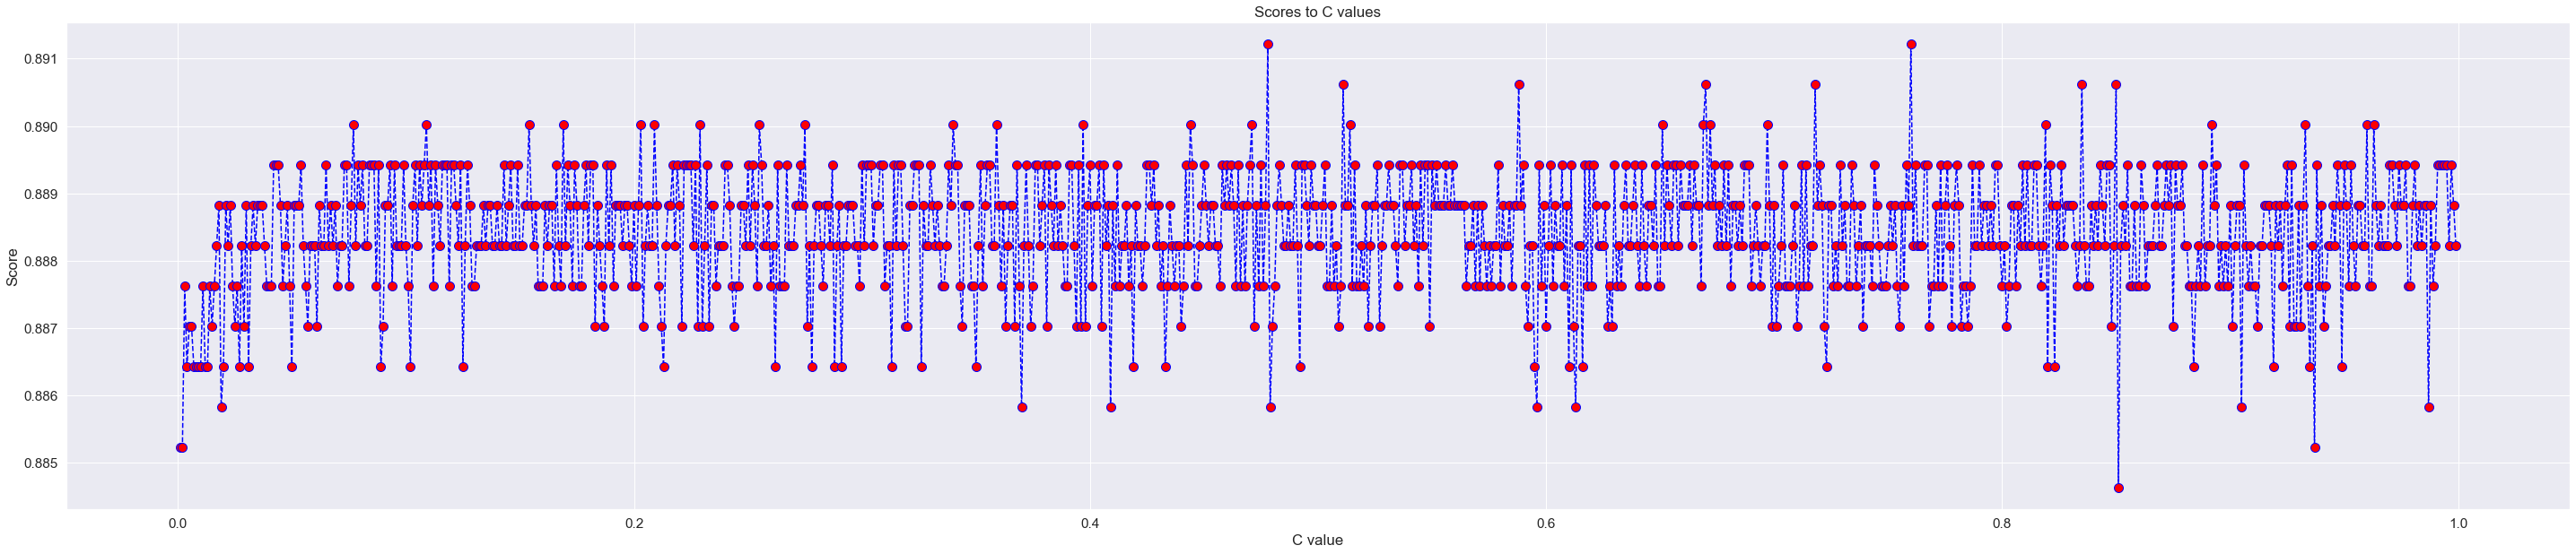

In [96]:
plt.figure(figsize=(50,10))
plt.plot(c_list,c_score,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Scores to C values')
plt.xlabel('C value')
plt.ylabel('Score')

print(f"""Best "C" value: {best_c}""")

Model predictions runtime: 0.0009799003601074219s
Accuracy score: 0.8870292887029289
MSE: 0.11297071129707113


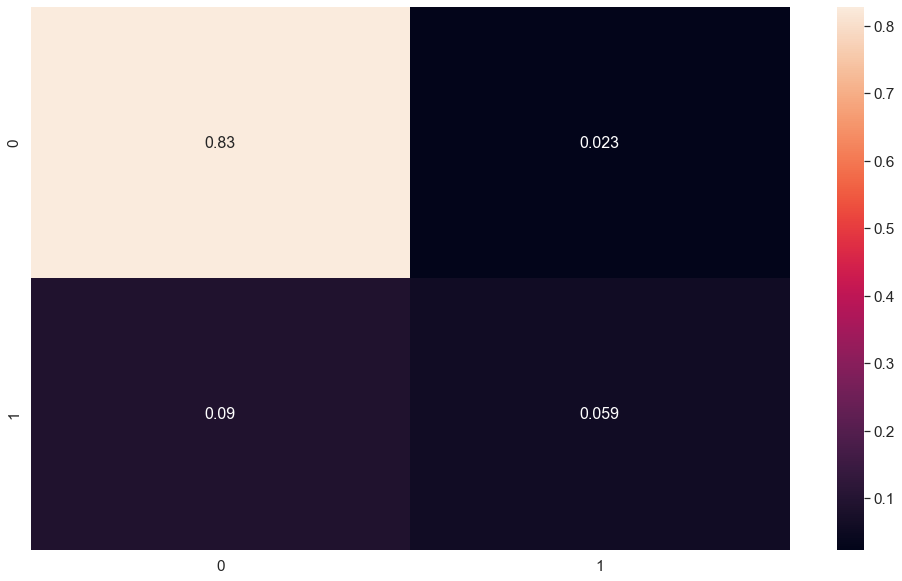

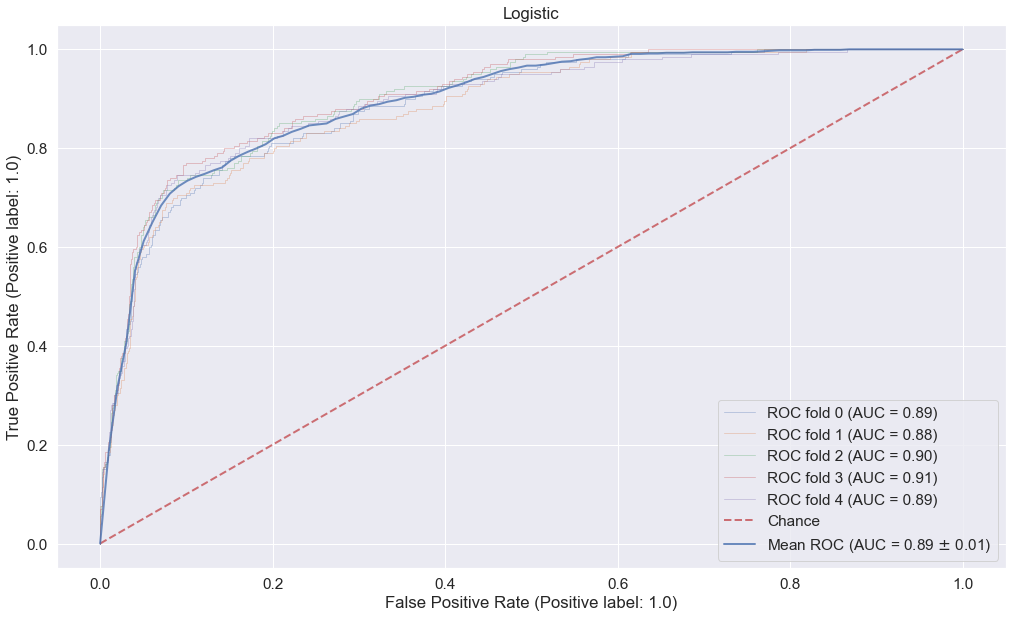

<Figure size 720x720 with 0 Axes>

In [97]:
lr = LogisticRegression(max_iter=1000000, C=best_c, penalty='l2').fit(x_train, y_train)
estimate_model_performance(lr, "Logistic", x_validation, y_validation, 5);


This time, we got a sligtly lower AUC score, but we can be encoreged that the fact that we used dimensinal reduction didn't affect badly. <br>
This might reduce the change of overfitting of our model.
<br>
<br>
Next, we want to see how each feature affected the model:

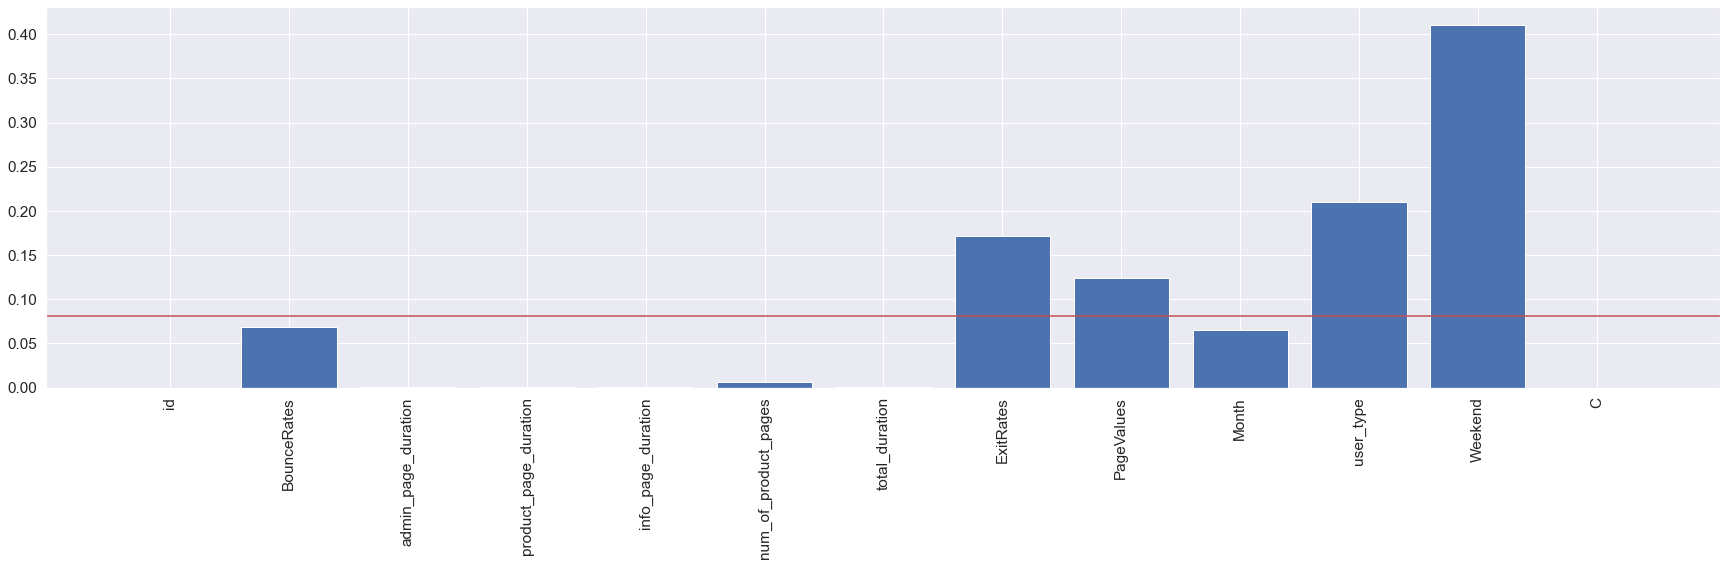

In [100]:
importance = lr.coef_[0]
avg = np.mean(np.abs(importance))
# plot feature importance
plt.figure(figsize=(30,7))
plt.bar(reduced_train_data.loc[:, reduced_train_data.columns != 'purchase'].columns, np.abs(importance))
plt.axhline(y=avg, color='r')
plt.xticks(reduced_train_data.loc[:, reduced_train_data.columns != 'purchase'].columns, rotation=90)
plt.show()

As we can see, We have one feature above all - Weekend. <br>
The intuition behind having the Weekend as the most impactful feauture is obvious - it tells us that people tend to spend more money on their free time.

### KNN

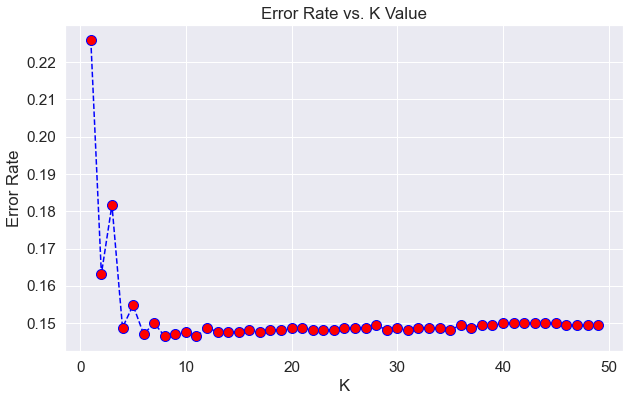

In [102]:
# Choose best K:
error_rate = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    pred_i = knn.predict(x_validation)
    error_rate.append(np.mean(pred_i != y_validation))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K');
plt.ylabel('Error Rate');

Using the elbow method, it appears that the best K to use on this set would be 8.

Model predictions runtime: 0.08150863647460938s
Accuracy score: 0.8535564853556485
MSE: 0.14644351464435146


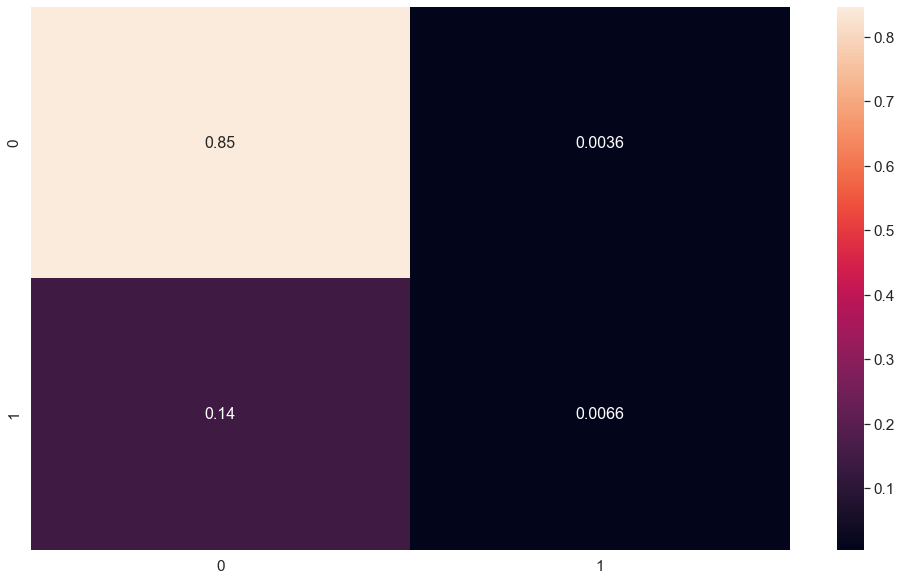

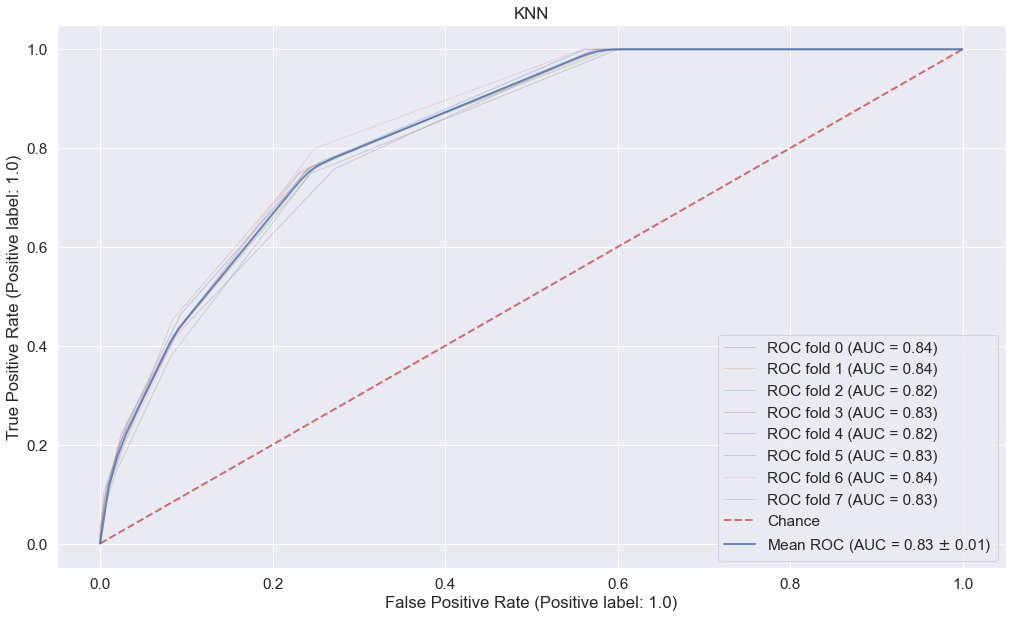

<Figure size 720x720 with 0 Axes>

In [112]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(x_train,y_train)
estimate_model_performance(knn, "KNN", x_validation, y_validation, 8)

We can see that the KNN model doesn't give as good results as the Logisitic Regression, with AUC score of 0.83.